### Librerías

In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [5]:
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams["figure.figsize"] = (8, 3)

### Datos de entrenamiento

In [6]:
df_train = pd.read_csv('../data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Baseline

#### Empleando solo datos utilizables sin pre-procesamiento

In [7]:
baseline_features = ["Pclass","Age","Parch","SibSp","Fare"]
df_baseline = df_train[baseline_features]

In [8]:
X,y = df_train[baseline_features], df_train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [19]:
baseline_model = RandomForestClassifier(n_estimators=150, max_depth=6)
_ = baseline_model.fit(X_train, y_train)

In [20]:
def eval_model(model, X_test, y_test, model_name="Model"):
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return acc

Model Accuracy: 0.7201


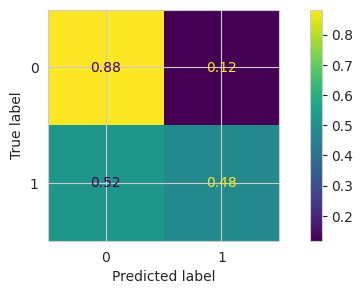

In [21]:
baseline_acc = eval_model(baseline_model, X_test, y_test)

Con el objetivo de comparar modelos, se emplea a continuación el modelo "dummy" (modelo bobo), el cual ignora las características de etrada. Sirve como una referencia simple contra otros modelos más avanzados.

In [18]:
dummy = DummyClassifier()
_ = dummy.fit(X_train, y_train)

Model Accuracy: 0.6007


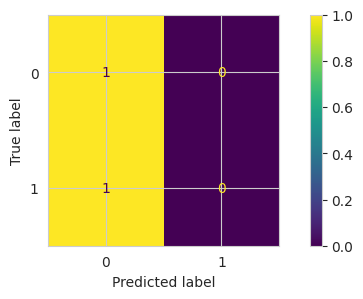

In [13]:
dummy_acc = eval_model(dummy, X_test=X_test, y_test=y_test)

#### Preprocesamiento básico
Se aplicarán mapeos y relleno de valores nulos en columnas como Sex, Age y Fare.

In [14]:
def basic_processing(df: pd.DataFrame) -> pd.DataFrame:

    # Rellenando edades nulas con la MEDIANA
    df["Age"] = df["Age"].fillna(df["Age"].median())

    # Rellenando tarifas nulas con la MEDIANA
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())

    # Mapear columna "Sex" a valores enteros
    df["Sex"] = df["Sex"].map({"female":0,"male":1})

    # rellena con el mas frecuente...
    df["Embarked"] = df["Embarked"].fillna("S")
    df["Embarked"] = df["Embarked"].map({"S":0,"Q":1,"C":2})

    return df

In [15]:
df_bp = basic_processing(df_train)

Model Accuracy: 0.8022


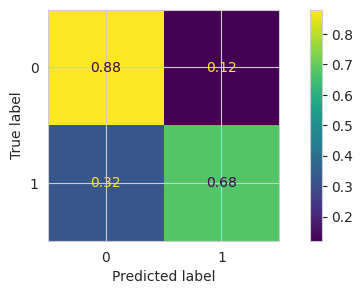

In [24]:
bp_features = [
    "Pclass",
    "Age",
    "Parch",
    "SibSp",
    "Fare",
    "Sex",
    "Embarked"
    ]

X_bp,y_bp = df_bp[bp_features], df_bp["Survived"]
X_train_bp, X_test_bp, y_train_bp, y_test_bp = train_test_split(X_bp,y_bp, test_size=0.3)

bp_model = RandomForestClassifier(n_estimators=150, max_depth=6)
_ = bp_model.fit(X_train_bp, y_train_bp)

y_pred = (bp_model.predict(X_test_bp) > 0.5).astype(int)
acc = accuracy_score(y_test_bp, y_pred)

bp_acc = eval_model(bp_model, X_test=X_test_bp, y_test=y_test_bp)

In [25]:
diferencia = (bp_acc - baseline_acc)*100
print(f"Con este preprocesamiento básico se obtuvo una mejora del {diferencia:.2f}% en la precisión (Accuracy) del modelo para el conjunto de test.")

Con este preprocesamiento básico se obtuvo una mejora del 8.21% en la precisión (Accuracy) del modelo para el conjunto de test.


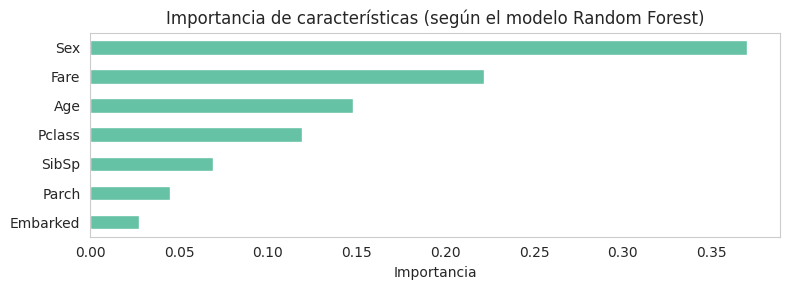

In [27]:
# importancia de las variables
importances = bp_model.feature_importances_
train_features = X_train_bp.columns
# Mostrar como gráfico
pd.Series(importances, index=train_features).sort_values(ascending=True).plot(kind='barh')
plt.title('Importancia de características (según el modelo Random Forest)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.grid()
plt.show()